### No white noise
In this notebook, no white noise was added to the Kalman-SEM.
This shall help to understand the effect of the white noise

In [528]:
import numpy as np
import xarray as xr
import yaml
from pathlib import Path
from kalman_reconstruction.custom_plot import (
    set_custom_rcParams,
    adjust_lightness,
    plot_colors,
    symmetrize_axis,
    handler_map_alpha,
    symmetrize_axis,
    plot_state_with_probability,
)
from reconstruct_climate_indices.idealized_ocean import sponge_ocean, oscillatory_ocean
from reconstruct_climate_indices.statistics import linear_regression_loglog
from kalman_reconstruction.pipeline import from_standard_dataset
from kalman_reconstruction.statistics import normalize, crosscorr, crosscorr_ds_da
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.linear_model import LinearRegression
from scipy import signal

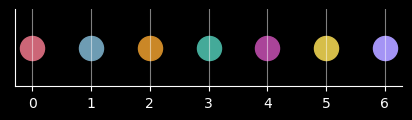

In [529]:
## LIGHT THEME
# plt.style.use("seaborn-v0_8-whitegrid")
# dark_color = [0.3, 0.3, 0.3]
# light_color = [0.95, 0.95, 0.95]
# lightness_0 = 0.75
# lightness_1 = 0.5
# cmap = "rocket"
# cmap_r = "rocket_r"

### DARK THEME
plt.style.use("dark_background")
dark_color = [0.7, 0.7, 0.7]
light_color = [0.2, 0.2, 0.2]
lightness_0 = 1.15
lightness_1 = 1.5
cmap = "rocket_r"
cmap_r = "rocket"


colors = set_custom_rcParams()
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.5

plot_colors(colors)

variables_color = dict()
variables_color["SAT"] = colors[0]
variables_color["SST"] = colors[2]
variables_color["DOT"] = colors[1]
variables_color["latent"] = colors[3]
variables_color["latent1"] = colors[3]
variables_color["latent2"] = colors[4]
variables_color["latent3"] = colors[5]
variables_color["loglikelihood"] = (colors[-1],)

In [530]:
REPO_PATH = Path(".").resolve().parent.parent


In [531]:
df = 0.115
tau0 = 5  # years
per0 = 48  # years
lambda0 = 2 / tau0 / (2 * np.pi)  # years
omega0 = 2 * np.pi / per0 / (2 * np.pi)  # years

# NOTE:
# The PSD units for the SAT are originally given in K^{2} d^{-1} y^{-1} but this is uglly
# So it is better to multuply the SAT by np.sqrt(1/365.25) to get it in K y^{-0.5}
SAT_factor = 1  # np.sqrt(1/365.25) # factor by which the input to the fft function should be multiplied to get the units mentioned above
SAT_PSD_units = r"$K^2 y^{-2}$"
SST_DOT_PSD_units = r"$K^2 y^{-1}$"

SAT_units = r"$K d^{-0.5}$"
SST_DOT_units = r"$K$"

print(rf"$\lambda_0$ = {lambda0}")
print(rf"$\omega_0$ = {omega0}")

$\lambda_0$ = 0.06366197723675814
$\omega_0$ = 0.020833333333333332


In [532]:
SubdataPath = "simplified_ocean_experiments"

# sponge_run_name = "unleashed-sloth-345"
# oscillatory_run_name = "silent-hare-702"
# final_dir = "1_latent"
# latent_variables = ["latent"]

# # sponge_run_name = "languid-gull-718"
# # oscillatory_run_name = "dashing-sloth-953"
# # final_dir = "2_latent_non_iterative"
# # latent_variables = ["latent1", "latent2"]

# sponge_run_name = "learned-hen-990"
# oscillatory_run_name = "sassy-bee-284"
# final_dir = "2_latent_iterative"
# file_name_ending = "latent2.nc"
# latent_variables = ["latent1", "latent2", "latent3"]

sponge_run_name = "learned-hen-990"
oscillatory_run_name = "sassy-bee-284"

# final_dir = "1_latent"
# file_name_ending = "_latent1.nc"
# latent_variables = ["latent1"]

# final_dir = "2_latent_iterative"
# file_name_ending = "_latent2.nc"
# latent_variables = ["latent1", "latent2"]

final_dir = "3_latent_iterative"
file_name_ending = "_latent3.nc"
latent_variables = ["latent1", "latent2", "latent3"]


sponge_select_dict = dict(
    tau0=tau0 * 365.25,
    # df=df,
)

oscillatory_select_dict = dict(
    per0=per0 * 365.25,
    tau0=tau0 * 365.25,
    # seed=331381460666,
)

results_path = (
    REPO_PATH / Path("results") / "earth_system_models" / "CMIP6" / "IdealizedOceans" / f"tau0_{tau0}_per0_{per0}" / final_dir
)
results_path.mkdir(parents=True, exist_ok=True)
SAVE_FIGURES = True


def save_fig(fig, relative_path, **kwargs):
    store_path = results_path / relative_path
    store_path.parent.mkdir(parents=True, exist_ok=True)
    if SAVE_FIGURES:
        fig.savefig(store_path, **kwargs)
    else:
        pass

In [533]:
# Sponge ocean
run_name = sponge_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + file_name_ending)
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    settings = yaml.safe_load(stream)
select_dict = sponge_select_dict

sponge_data = experiments.sel(select_dict)
sponge_kalman = experiments_kalman.sel(select_dict)
sponge_kalman_states = experiments_kalman_states.sel(select_dict)
sponge_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
    select_dict
)

sponge_kalman_states_all = sponge_kalman_states.copy()
sponge_kalman_states = sponge_kalman_states.isel(kalman_iteration = -1)


In [534]:
# Oscillatory ocean
run_name = oscillatory_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + file_name_ending)
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)


# Read YAML file
with open(SettingsPath, "r") as stream:
    settings = yaml.safe_load(stream)
select_dict = oscillatory_select_dict


oscillatory_data = experiments.sel(select_dict)
oscillatory_kalman = experiments_kalman.sel(select_dict)
oscillatory_kalman_states = experiments_kalman_states.sel(select_dict)
oscillatory_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
    select_dict
)
oscillatory_kalman_states_all = oscillatory_kalman_states.copy()
oscillatory_kalman_states = oscillatory_kalman_states.isel(kalman_iteration = -1)


### Get the length, timestep and so on

In [535]:
def get_dt(l):
    idx = 0
    for current_dataset in l:
        if idx == 0:
            dt = current_dataset.time[1] - current_dataset.time[0]
        else:
            assert dt == current_dataset.time[1] - current_dataset.time[0]
    return dt


def get_T(l):
    idx = 0
    for current_dataset in l:
        if idx == 0:
            T = current_dataset.time[-1] - current_dataset.time[0]
        else:
            assert T == current_dataset.time[-1] - current_dataset.time[0]
    return T / 365.25


dt = get_dt(
    [oscillatory_data, oscillatory_kalman_states, sponge_data, sponge_kalman_states]
).values
print(dt)
years = np.round(
    get_T(
        [oscillatory_data, oscillatory_kalman_states, sponge_data, sponge_kalman_states]
    ).values,
    decimals=2,
)
print(years)
# years = 1000
time_steps = years * 365.25 / dt
fs = 365.25 / dt  # 1/years

30.4375
149.92


In [536]:
sponge_kalman_states["time_years"]
# oscillatory_kalman_states["time_years"]

<xarray.DataArray 'time_years' (time: 1800)>
array([0.00000000e+00, 8.33333333e-02, 1.66666667e-01, ...,
       1.49750000e+02, 1.49833333e+02, 1.49916667e+02])
Coordinates:
  * time              (time) float64 0.0 30.44 60.88 ... 5.473e+04 5.476e+04
    kalman_iteration  int32 29
    tau0              float64 1.826e+03
    time_years        (time) float64 0.0 0.08333 0.1667 ... 149.8 149.8 149.9

## Log likelihood

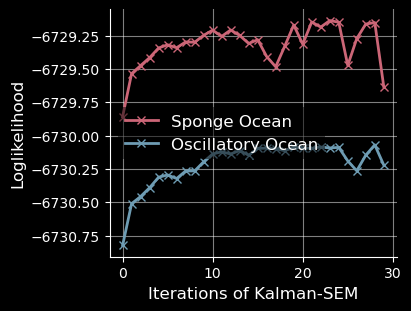

In [537]:
fig, ax = plt.subplots(nrows=1, ncols=1, layout="constrained", figsize=(4, 3))

ax.plot(
    sponge_kalman["kalman_iteration"],
    sponge_kalman["log_likelihod"],
    label="Sponge Ocean",
    linewidth=2,
    marker="x",
)
ax.plot(
    oscillatory_kalman["kalman_iteration"],
    oscillatory_kalman["log_likelihod"],
    label="Oscillatory Ocean",
    linewidth=2,
    marker="x",
)
ax.set_xlabel("Iterations of Kalman-SEM")
ax.set_ylabel("Loglikelihood")
ax.legend(loc="center left")
# ax.set_title("Loglikelihood against iteartions of Kalman-SEM")

fig_name = f"Loglikelihood_{years}y"
save_fig(fig=fig, relative_path=fig_name + ".svg")
# save_fig(fig=fig, relative_path=fig_name + ".png")

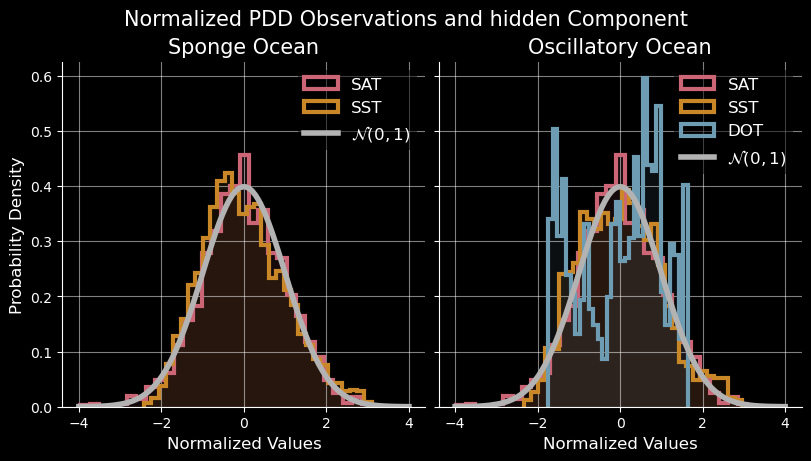

In [538]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, layout="constrained", sharex=True, sharey=True
)

stepfill_kwargs = dict(
    bins=31,
    histtype="stepfilled",
    density=True,
    alpha=0.1,
)
step_kwargs = dict(
    bins=31,
    histtype="step",
    density=True,
    alpha=1,
    linewidth=3,
)

axs_sponge = axs[0]
axs_oscill = axs[1]
axs_sponge.set_title("Sponge Ocean")
axs_oscill.set_title("Oscillatory Ocean")

# Plot sponge distribution
for var in ["SAT", "SST"]:
    his = axs_sponge.hist(
        normalize(sponge_data[var], method="mean"),
        label=var,
        color=variables_color[var],
        **step_kwargs,
    )
    axs_sponge.hist(
        normalize(sponge_data[var], method="mean"),
        color=variables_color[var],
        **stepfill_kwargs,
    )

# Plot Oscilltor distribution
for var in ["SAT", "SST", "DOT"]:
    his = axs_oscill.hist(
        normalize(oscillatory_data[var], method="mean"),
        label=var,
        color=variables_color[var],
        **step_kwargs,
    )
    axs_oscill.hist(
        normalize(oscillatory_data[var], method="mean"),
        color=variables_color[var],
        **stepfill_kwargs,
    )

# Plot normal distribution
import scipy.stats as stats

mu = 0
variance = 1
width = 4
sigma = np.sqrt(variance)
x = np.linspace(mu - width * sigma, mu + width * sigma, 100)
for ax in axs.flatten():
    ax.plot(
        x,
        stats.norm.pdf(x, mu, sigma),
        color=dark_color,
        label=r"$\mathcal{N}(0,1)$",
        linewidth=4,
    )
    ax.legend()
    ax.set_xlabel("Normalized Values")
    symmetrize_axis(axes=ax, axis="x")
axs[0].set_ylabel("Probability Density")

fig.suptitle("Normalized PDD Observations and hidden Component")

fig_name = f"Distribution_{years}y"
save_fig(fig=fig, relative_path=fig_name + ".svg")
# save_fig(fig=fig, relative_path=fig_name + ".png")

## Time evolution

In [539]:
# fig, axs = plt.subplots(
#     nrows=3, ncols=2, layout="constrained", sharex=True, figsize=(10, 4.5 * 1.25)
# )
# kwargs = dict(linestyle="-", linewidth="2", marker=".", alpha=0.75)

# idx = 0  # x index to plot the text at

# axs_sponge = axs[:, 0]
# axs_oscill = axs[:, 1]
# axs_sponge[0].set_title("Sponge Ocean")
# axs_oscill[0].set_title("Oscillatory Ocean")

# # -------------------
# # Plot SPONGE OCEAN
# # -------------------

# # Plot SAT
# var = "SAT"
# axs_sponge[0].plot(
#     sponge_data["time_years"],
#     sponge_data[var],
#     label=var,
#     color=variables_color[var],
#     **kwargs,
# )

# # Plot SST
# var = "SST"
# axs_sponge[1].plot(
#     sponge_data["time_years"],
#     sponge_data[var],
#     label=var,
#     color=variables_color[var],
#     **kwargs,
# )


# # -------------------
# # Plot Oscillatory OCEAN
# # -------------------
# var = "SAT"
# axs_oscill[0].plot(
#     oscillatory_data["time_years"],
#     oscillatory_data[var],
#     label=var,
#     color=variables_color[var],
#     **kwargs,
# )

# for var in ["SST", "DOT"]:
#     axs_oscill[1].plot(
#         oscillatory_data["time_years"],
#         oscillatory_data[var],
#         label=var,
#         color=variables_color[var],
#         **kwargs,
#     )


# # -------------------
# # PLOT RECONSTRUCTION
# # -------------------
# # Sponge
# for var in latent_variables:
#     axs_sponge[2].plot(
#         sponge_kalman_states["time_years"],
#         sponge_kalman_states[var],
#         label=var,
#         color=variables_color[var],
#         **kwargs,
#     )
# var = "SAT"
# axs_oscill[2].plot(
#     sponge_data["time_years"],
#     sponge_data[var],
#     label=f"{var} / Hidden",
#     color=variables_color[var],
#     **dict(
#         linestyle="-",
#         linewidth="2",
#         # marker=".",
#         alpha=0.5,
#     ),
# )
# symmetrize_axis(axes=axs_sponge[2], axis="y")
# # Oscillatory
# for var in latent_variables:
#     axs_oscill[2].plot(
#         oscillatory_kalman_states["time_years"],
#         normalize(oscillatory_kalman_states[var]),
#         label=var,
#         color=variables_color[var],
#         **kwargs,
#     )
# var = "SAT"
# axs_oscill[2].plot(
#     oscillatory_data["time_years"],
#     normalize(oscillatory_data[var]),
#     label=f"{var} / Hidden",
#     color=variables_color[var],
#     **dict(
#         linestyle="--",
#         linewidth="2",
#         # marker=".",
#         alpha=0.5,
#     ),
# )
# var = "DOT"
# axs_oscill[2].plot(
#     oscillatory_data["time_years"],
#     normalize(oscillatory_data[var]),
#     label=f"{var} / Hidden",
#     color=variables_color[var],
#     **dict(
#         linestyle="--",
#         linewidth="2",
#         # marker=".",
#         alpha=0.5,
#     ),
# )


# # Label and lims for SAT
# axs_sponge[0].set_ylabel(f"{SAT_units}")
# axs_oscill[0].set_ylabel(f"{SAT_units}")
# axs_oscill[0].set_ylim([-0.5, 0.5])
# axs_sponge[0].set_ylim([-0.5, 0.5])

# # Label and lims for SST and DOT
# axs_sponge[1].set_ylabel(f"{SST_DOT_units}")
# axs_oscill[1].set_ylabel(f"{SST_DOT_units}")
# axs_oscill[1].set_ylim([-12, 12])
# axs_sponge[1].set_ylim([-12, 12])

# # Label and lims for latent and DOT
# axs_sponge[2].set_ylabel(f"value")
# axs_oscill[2].set_ylabel(f"value")
# # axs_oscill[2].set_ylim([-12, 12])
# # axs_sponge[2].set_ylim([-12, 12])

# # set xlabel
# axs_oscill[2].set_xlabel("Time in y")
# axs_sponge[2].set_xlabel("Time in y")

# for ax in axs.flatten():
#     ax.set_xlim([0, 150])
#     ax.legend(
#         ncols=2,
#         loc="lower left",
#         handlelength=1,
#         handletextpad=0.15,
#         columnspacing=0.2,
#         handler_map=handler_map_alpha(),
#     )

# axs_oscill[2].legend(
#     ncols=2,
#     loc="lower left",
#     handlelength=1,
#     handletextpad=0.15,
#     columnspacing=0.2,
#     # handler_map = handler_map_alpha()
# )
# save_fig(fig=fig, relative_path=f"Time_evolution_all_states_{years}y.svg")

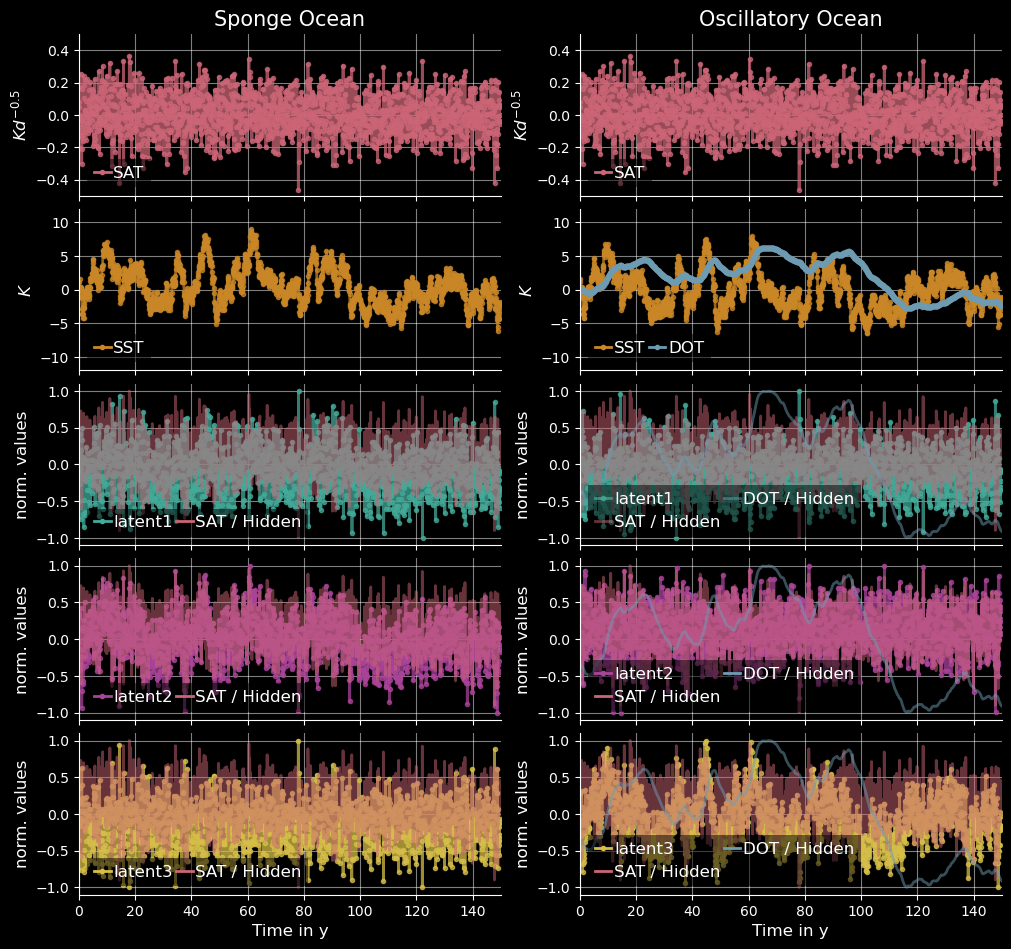

In [540]:

nrows = 2 + len(latent_variables)
fig_height = 4.5 * 1.25 / 3 * nrows
fig, axs = plt.subplots(
    nrows=nrows, ncols=2, layout="constrained", sharex=True, figsize=(10, fig_height)
)
kwargs = dict(linestyle="-", linewidth="2", marker=".", alpha=0.75)


idx = 0  # x index to plot the text at

axs_sponge = axs[:, 0]
axs_oscill = axs[:, 1]
axs_sponge[0].set_title("Sponge Ocean")
axs_oscill[0].set_title("Oscillatory Ocean")

# -------------------
# Plot SPONGE OCEAN
# -------------------

# Plot SAT
var = "SAT"
axs_sponge[0].plot(
    sponge_data["time_years"],
    sponge_data[var],
    label=var,
    color=variables_color[var],
    **kwargs,
)

# Plot SST
var = "SST"
axs_sponge[1].plot(
    sponge_data["time_years"],
    sponge_data[var],
    label=var,
    color=variables_color[var],
    **kwargs,
)


# -------------------
# Plot Oscillatory OCEAN
# -------------------
var = "SAT"
axs_oscill[0].plot(
    oscillatory_data["time_years"],
    oscillatory_data[var],
    label=var,
    color=variables_color[var],
    **kwargs,
)

for var in ["SST", "DOT"]:
    axs_oscill[1].plot(
        oscillatory_data["time_years"],
        oscillatory_data[var],
        label=var,
        color=variables_color[var],
        **kwargs,
    )


# -------------------
# PLOT RECONSTRUCTION
# -------------------
# Sponge
for i, var in enumerate(latent_variables):
    axs_sponge[2+i].plot(
        sponge_kalman_states["time_years"],
        normalize(sponge_kalman_states[var]),
        label=var,
        color=variables_color[var],
        **kwargs,
    )
    var = "SAT"
    axs_sponge[2+i].plot(
        sponge_data["time_years"],
        normalize(sponge_data[var]),
        label=f"{var} / Hidden",
        color=variables_color[var],
        **dict(
            linestyle="-",
            linewidth="2",
            # marker=".",
            alpha=0.5,
        ),
    )
    symmetrize_axis(axes=axs_sponge[2], axis="y")
# Oscillatory
for i, var in enumerate(latent_variables):
    axs_oscill[2+i].plot(
        oscillatory_kalman_states["time_years"],
        normalize(oscillatory_kalman_states[var]),
        label=var,
        color=variables_color[var],
        **kwargs,
    )
    var = "SAT"
    axs_oscill[2+i].plot(
        oscillatory_data["time_years"],
        normalize(oscillatory_data[var]),
        label=f"{var} / Hidden",
        color=variables_color[var],
        **dict(
            linestyle="-",
            linewidth="2",
            # marker=".",
            alpha=0.5,
        ),
    )
    var = "DOT"
    axs_oscill[2+i].plot(
        oscillatory_data["time_years"],
        normalize(oscillatory_data[var]),
        label=f"{var} / Hidden",
        color=variables_color[var],
        **dict(
            linestyle="-",
            linewidth="2",
            # marker=".",
            alpha=0.5,
        ),
    )


# Label and lims for SAT
axs_sponge[0].set_ylabel(f"{SAT_units}")
axs_oscill[0].set_ylabel(f"{SAT_units}")
axs_oscill[0].set_ylim([-0.5, 0.5])
axs_sponge[0].set_ylim([-0.5, 0.5])

# Label and lims for SST and DOT
axs_sponge[1].set_ylabel(f"{SST_DOT_units}")
axs_oscill[1].set_ylabel(f"{SST_DOT_units}")
axs_oscill[1].set_ylim([-12, 12])
axs_sponge[1].set_ylim([-12, 12])

# Label and lims for latent and DOT
for i in range(len(latent_variables)):
    axs_sponge[2+i].set_ylabel("norm. values")
    axs_oscill[2+i].set_ylabel("norm. values")
# axs_oscill[2].set_ylim([-12, 12])
# axs_sponge[2].set_ylim([-12, 12])

# set xlabel
axs_oscill[-1].set_xlabel("Time in y")
axs_sponge[-1].set_xlabel("Time in y")

for ax in axs.flatten():
    ax.set_xlim([0, 150])
    ax.legend(
        ncols=2,
        loc="lower left",
        handlelength=1,
        handletextpad=0.15,
        columnspacing=0.2,
        handler_map=handler_map_alpha(),
    )

axs_oscill[2].legend(
    ncols=2,
    loc="lower left",
    handlelength=1,
    handletextpad=0.15,
    columnspacing=0.2,
    # handler_map = handler_map_alpha()
)
save_fig(fig=fig, relative_path=f"Time_evolution_all_states_{years}y.svg")
save_fig(fig=fig, relative_path=f"Time_evolution_all_states_{years}y.png", 
         dpi=300
         )

## Spectral Analysis

In [541]:
welch_window_width = 100

In [542]:
def plot_all_frequency_analysis(
    x: np.ndarray, ax: plt.Axes, color: str, f_low: float, idx: int, var: str
) -> None:
    # no welch method applied:
    window = "boxcar",
    nperseg = len(x)
    frequencies, spectrum = signal.welch(
        x=x,
        fs=fs,
        window= window,
        nperseg=nperseg,
    )
    ax.loglog(
        frequencies,
        spectrum,
        label=var,
        alpha=0.7,
        color=color,
    )

    # no Welch method applied:
    # window = boxcar,
    # nperseg = len(x)
    # frequencies, spectrum = signal.welch(
    #     x=x,
    #     fs=fs,
    #     window="hann",
    #     nperseg=int(welch_window_width * fs),
    # )
    # ax.loglog(
    #     frequencies,
    #     spectrum,
    #     label=f"{var}",
    #     color=adjust_lightness(color, lightness_0),
    # )

    # create linear regression in loglog space
    frequencies_linear, spectrum_linear, regression = linear_regression_loglog(
        frequencies=frequencies,
        spectrum=spectrum,
        weights="f_inverse",
        f_low=f_low,
    )
    slope = regression.coef_[0, 0]
    ax.loglog(
        frequencies_linear,
        spectrum_linear,
        color=adjust_lightness(color, lightness_1),
    )
    ax.text(
        frequencies_linear[idx],
        spectrum_linear[idx],
        f"m= {slope:.2f}",
        ha="right",
        va="top",
        bbox=dict(facecolor=light_color, edgecolor="None", alpha=0.55),
        color=adjust_lightness(color, lightness_1),
    )

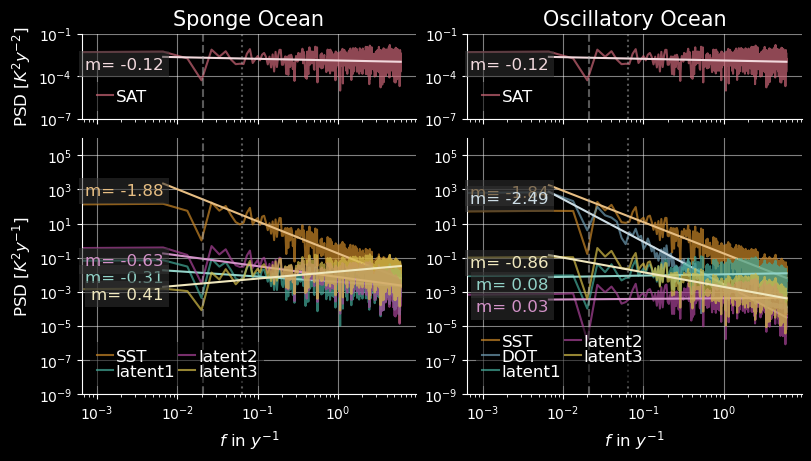

In [543]:
gs_kw = dict(height_ratios=[0.5, 1.5])
fig, axs = plt.subplots(
    nrows=2, ncols=2, layout="constrained", gridspec_kw=gs_kw, sharex=True, sharey=False
)
kwargs = dict(
    linestyle="-",
    linewidth="1",
    marker=".",
)

idx = 1  # x index to plot the text at

axs_sponge = axs[:, 0]
axs_oscill = axs[:, 1]
axs_sponge[0].set_title("Sponge Ocean")
axs_oscill[0].set_title("Oscillatory Ocean")

# ------------------
# plot SAT
# ------------------
var = "SAT"
for current_dataset, ax in zip(
    [sponge_data, oscillatory_data], [axs_sponge[0], axs_oscill[0]]
):
    color = variables_color[var]
    x = current_dataset[var].values
    plot_all_frequency_analysis(
        x=x,
        ax=ax,
        color=color,
        f_low=0,
        idx=idx,
        var=var,
    )


# ------------------
# plot SST
# ------------------
var = "SST"
for current_dataset, ax, f_low in zip(
    [sponge_data, oscillatory_data],  # datasets
    [axs_sponge[1], axs_oscill[1]],  # axes object to plot into
    [lambda0, omega0],  # lowest frequency to use for linear regression
):
    x = current_dataset[var].values
    color = variables_color[var]

    plot_all_frequency_analysis(
        x=x,
        ax=ax,
        color=color,
        f_low=f_low,
        idx=idx,
        var=var,
    )


# ------------------
# plot DOT
# ------------------
var = "DOT"
for current_dataset, ax, f_low in zip(
    [oscillatory_data],  # datasets
    [axs_oscill[1]],  # axes object to plot into
    [omega0],  # lowest frequency to use for linear regression
):
    x = current_dataset[var].values
    color = variables_color[var]
    plot_all_frequency_analysis(
        x=x,
        ax=ax,
        color=color,
        f_low=f_low,
        idx=idx,
        var=var,
    )


# ------------------------------
# plot latent
# ------------------------------
latent_f_low = 1 / welch_window_width
for var in latent_variables:
    for current_dataset, ax in zip(
        [sponge_kalman_states, oscillatory_kalman_states],
        [axs_sponge[1], axs_oscill[1]],
    ):
        color = variables_color[var]
        x = current_dataset[var].values

        plot_all_frequency_analysis(
            x=x,
            ax=ax,
            color=color,
            f_low=latent_f_low,
            idx=idx,
            var=var,
        )


for ax in axs.flatten():
    # plot 1 / lambda9
    ax.axvline(lambda0, color=dark_color, linestyle=":", alpha=0.5)
    # plot 1 / omega0
    ax.axvline(omega0, color=dark_color, linestyle="--", alpha=0.5)
    # plot 1 / welch window width
    # ax.axvline(1 / welch_window_width, color=dark_color, linestyle="-", alpha=0.5)
    # plot legend
    ax.legend(
        ncols=2,
        loc="lower left",
        handlelength=1,
        labelspacing=0.01,
        handletextpad=0.15,
        columnspacing=0.2,
    )

# fig.suptitle(
#     f"Power Density Spectrum of Latent variable, Observations and hidden Component"
# )
axs_sponge[0].set_ylabel(f"PSD [{SAT_PSD_units}]")
axs_sponge[1].set_ylabel(f"PSD [{SST_DOT_PSD_units}]")

axs_oscill[1].set_xlabel(r"$f$ in $y^{-1}$")
axs_sponge[1].set_xlabel(r"$f$ in $y^{-1}$")

for ax in [axs_sponge[1], axs_oscill[1]]:
    ax.set_ylim(ymin=10 ** (-9))
    ax.set_ylim(ymax=10 ** (6))
for ax in [axs_sponge[0], axs_oscill[0]]:
    ax.set_ylim(ymin=10 ** (-7))
    ax.set_ylim(ymax=10 ** (-1))
for ax in axs.flatten():
    ax.set_xlim(10 ** np.array([-3.18890756, 0.96705881]))

# remove the y ticks for Oscillatory ocean
# for ax in axs_oscill :
#     ax.tick_params(
#         axis='y',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         left=False,      # ticks along the bottom edge are off
#         labelleft=False) # labels along the bottom edge are off

fig_name = f"Frequency_{years}y"
save_fig(fig=fig, relative_path=fig_name + "_simple.svg")
# save_fig(fig=fig, relative_path=fig_name + "_simple.svg")
# save_fig(fig=fig, relative_path=fig_name + "_simple.png")

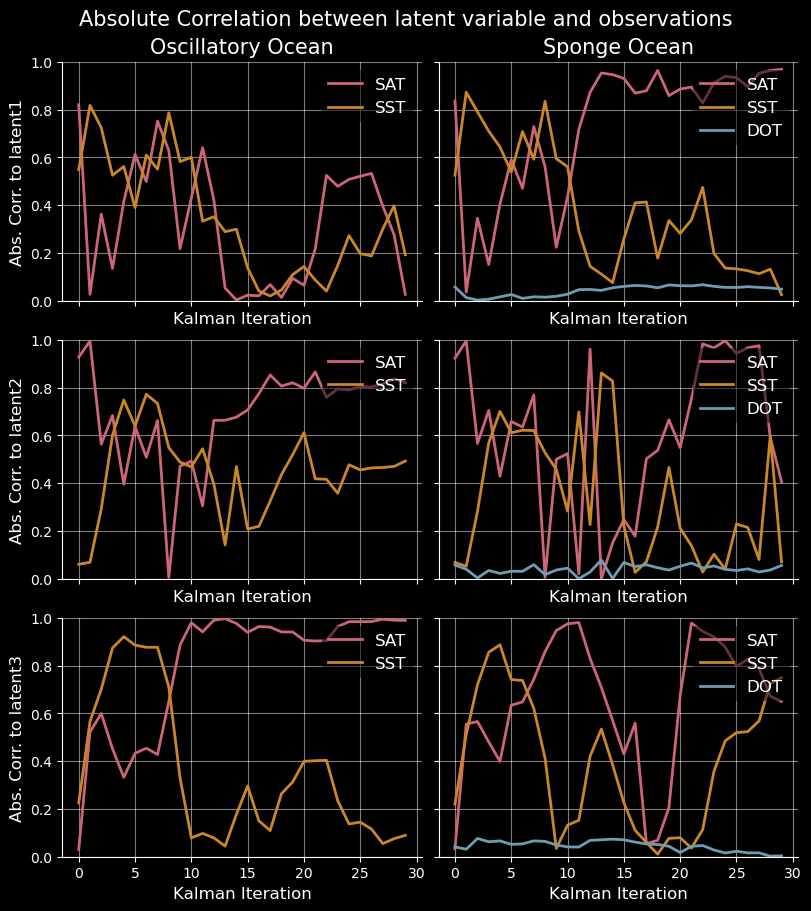

In [544]:
fig_height = 3 * len(latent_variables)
fig, axs = plt.subplots(
    nrows=len(latent_variables), ncols=2, layout="constrained", sharex=True, sharey=True, figsize=(8, fig_height)
    )

if axs.ndim == 1:
    axs = axs[None, :]
else :
    pass 

for j, latent_var_name in enumerate(latent_variables):
    corr_latent_oscillatory = crosscorr_ds_da(oscillatory_data, oscillatory_kalman_states_all[latent_var_name], lag=0, dim = "time")
    corr_latent_sponge = crosscorr_ds_da(sponge_data, sponge_kalman_states_all[latent_var_name], lag=0, dim = "time")
    for var in ["SAT", "SST"]:
        axs[j, 0].plot(
            corr_latent_sponge["kalman_iteration"],
            np.abs(corr_latent_sponge[var]),
            label = var,
            color = variables_color[var],
            linewidth = 2,
        )
    for var in ["SAT", "SST", "DOT"]:
        axs[j, 1].plot(
            corr_latent_oscillatory["kalman_iteration"], 
            np.abs(corr_latent_oscillatory[var]),
            label = var,
            color = variables_color[var],
            linewidth = 2,
        )
    
for ax in axs.flatten():
    ax.legend()
    ax.set_xlabel("Kalman Iteration")

for j, latent_var in enumerate(latent_variables):
    axs[j,0].set_ylabel(f"Abs. Corr. to {latent_var}")
    axs[j,0].set_ylim([0,1])
axs[0, 0].set_title("Oscillatory Ocean")
axs[0, 1].set_title("Sponge Ocean")
fig.suptitle("Absolute Correlation between latent variable and observations")

fig_name = f"Correlation_latent{years}y"
save_fig(fig=fig, relative_path=fig_name + ".svg")

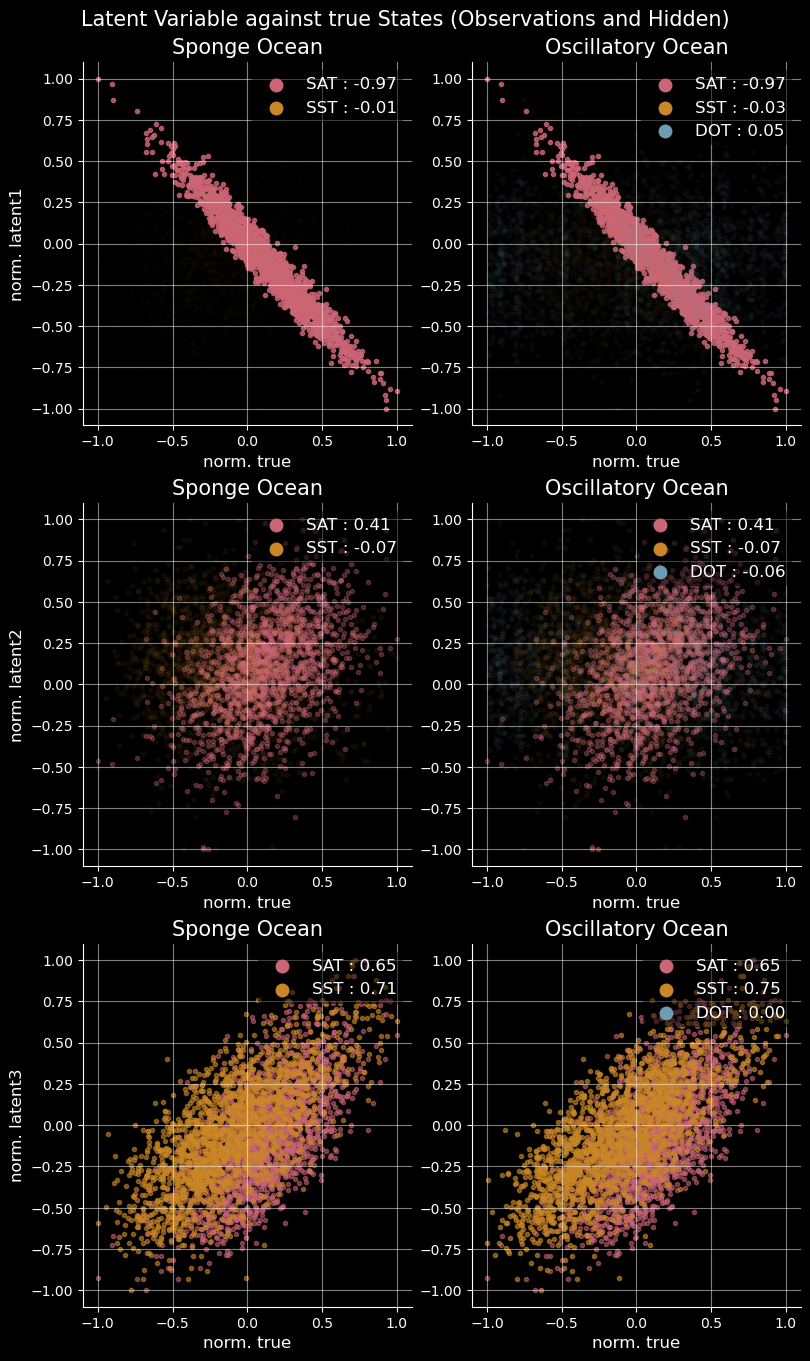

In [545]:
fig_height = 4.5 * len(latent_variables)
fig, axs = plt.subplots(
    nrows=len(latent_variables),
    ncols=2,
    layout="constrained",
    figsize=(8, fig_height),
)
if axs.ndim == 1:
    axs = axs[None, :]
else :
    pass 

for i, current_kalman_states, current_data, title in zip(
    [0, 1],
    [sponge_kalman_states, oscillatory_kalman_states],
    [sponge_data, oscillatory_data],
    ["Sponge Ocean", "Oscillatory Ocean"],
):
    for j, latent_var_name in enumerate(latent_variables):
        ax = axs[j,i]
        reconst = normalize(current_dataset, method="11")
        truth = normalize(current_data, method="11")
        for var in truth.data_vars:
            try:
                corr = xr.corr(truth[var], reconst[latent_var_name])
                ax.scatter(
                    truth[var],
                    reconst[latent_var_name],
                    marker=".",
                    color=variables_color[var],
                    alpha=np.abs(corr.values) / 1.2,
                    label=f"{var} : {corr:.2f}",
                )
            except:
                pass
        ax.set_title(title)
        ax.set_xlabel("norm. true")
        ax.legend(
            markerscale=3,
            handler_map=handler_map_alpha(),
        )
        symmetrize_axis(axes=ax, axis=0)
        symmetrize_axis(axes=ax, axis=1)

for i, latent_var_name in enumerate(latent_variables):
    axs[i, 0].set_ylabel(f"norm. {latent_variables[i]}")

fig.suptitle(f"Latent Variable against true States (Observations and Hidden)")
fig_name = f"Truth_against_Latent_{years}y"
# save_fig(fig=fig, relative_path=fig_name + ".svg")
save_fig(fig=fig, relative_path=fig_name + ".png", 
         **dict(dpi=300, bbox_inches="tight")
         )

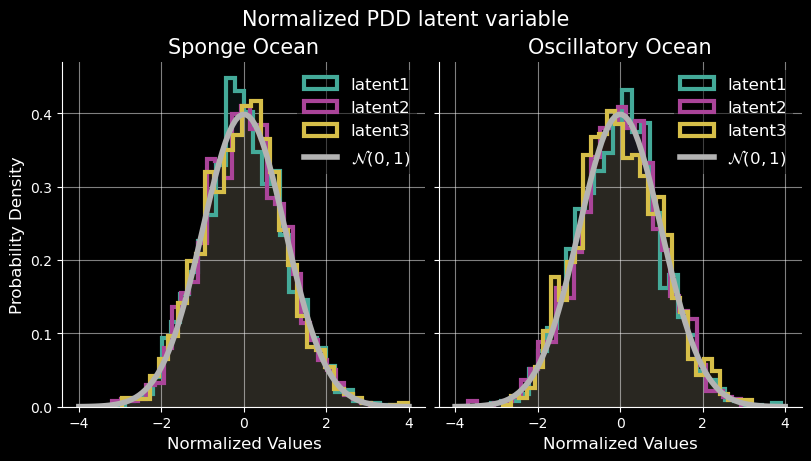

In [546]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, layout="constrained", sharex=True, sharey=True
)

stepfill_kwargs = dict(
    bins=31,
    histtype="stepfilled",
    density=True,
    alpha=0.1,
)
step_kwargs = dict(
    bins=31,
    histtype="step",
    density=True,
    alpha=1,
    linewidth=3,
)

axs_sponge = axs[0]
axs_oscill = axs[1]
axs_sponge.set_title("Sponge Ocean")
axs_oscill.set_title("Oscillatory Ocean")

# Plot sponge distribution
for var in latent_variables:
    his = axs_sponge.hist(
        normalize(sponge_kalman_states[var], method="mean"),
        label=var,
        color=variables_color[var],
        **step_kwargs,
    )
    axs_sponge.hist(
        normalize(sponge_kalman_states[var], method="mean"),
        color=variables_color[var],
        **stepfill_kwargs,
    )

# Plot Oscilltor distribution
for var in latent_variables:
    his = axs_oscill.hist(
        normalize(oscillatory_kalman_states[var], method="mean"),
        label=var,
        color=variables_color[var],
        **step_kwargs,
    )
    axs_oscill.hist(
        normalize(oscillatory_kalman_states[var], method="mean"),
        color=variables_color[var],
        **stepfill_kwargs,
    )

# Plot normal distribution
import scipy.stats as stats

mu = 0
variance = 1
width = 4
sigma = np.sqrt(variance)
x = np.linspace(mu - width * sigma, mu + width * sigma, 100)
for ax in axs.flatten():
    ax.plot(
        x,
        stats.norm.pdf(x, mu, sigma),
        color=dark_color,
        label=r"$\mathcal{N}(0,1)$",
        linewidth=4,
    )
    ax.legend()
    ax.set_xlabel("Normalized Values")
    symmetrize_axis(axes=ax, axis="x")
axs[0].set_ylabel("Probability Density")
fig.suptitle("Normalized PDD latent variable")

fig_name = f"Distribution_{years}y_latent"
save_fig(fig=fig, relative_path=fig_name + ".svg")
# save_fig(fig=fig, relative_path=fig_name + ".png")

In [547]:
oscillatory_kalman_states_all

<xarray.Dataset>
Dimensions:           (time: 1800, kalman_iteration: 30, state_name_copy: 4)
Coordinates:
  * time              (time) float64 0.0 30.44 60.88 ... 5.473e+04 5.476e+04
  * kalman_iteration  (kalman_iteration) int32 0 1 2 3 4 5 ... 24 25 26 27 28 29
    per0              float64 1.753e+04
    tau0              float64 1.826e+03
    time_years        (time) float64 0.0 0.08333 0.1667 ... 149.8 149.8 149.9
  * state_name_copy   (state_name_copy) object 'SST' 'latent1' ... 'latent3'
Data variables:
    SST               (kalman_iteration, time) float64 ...
    latent1           (kalman_iteration, time) float64 ...
    latent2           (kalman_iteration, time) float64 ...
    latent3           (kalman_iteration, time) float64 ...
    loglikelihood     (kalman_iteration) float64 ...